In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset (replace path with your dataset location)
df = pd.read_csv("F:/003MYPROJECTS/ENCRYPTIXprojects/Credit card fraud detection/creditcard.csv")

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Here, V1 to V28 features in this dataset are derived from Principal Component Analysis (PCA), in such a way that the dimensionality of the original transaction data is reduced also maintaining anonymality. These transformed features capture important patterns while maintaining privacy, making them uncorrelated and ranked by variance explained. Unlike interpretable columns like "Amount" or "Time," they don’t have direct real-world meanings but still play a crucial role in detecting fraud.

# Explore data

In [3]:
df.drop_duplicates(inplace=True)

Dataset shape: (283726, 31)
Class
0    283253
1       473
Name: count, dtype: int64
Duplicated data: 0


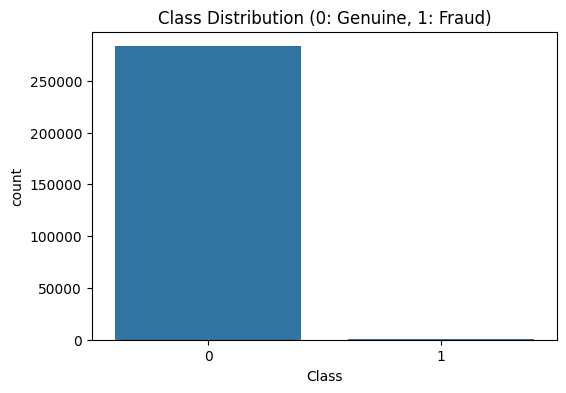

In [4]:
print(f"Dataset shape: {df.shape}")

print(df['Class'].value_counts())

print(f"Duplicated data: {df.duplicated().sum()}")

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0: Genuine, 1: Fraud)")
plt.show()


Looking at this count plot, we can clearly see severe class imbalance in the dataset. here, majority of transactions belong to the 'Genuine'(0), while the number of fraud(1) is significantly lower. This imbalance is common in fraud detection datasets, as fraud cases are rare compared to genuine transactions. this uneven distribution can affect performance, making it biased toward the majority class. So, I have used SMOTE (Synthetic Minority Over-sampling Technique) balance the dataset below."

In [5]:
# Check for missing values
print(df.isnull().sum().sum())  # 0 if no missing values

0


In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


#  Feature Scaling

Here, V1 to V28 is mostly PCA-transformed, but 'Amount' and 'Time' needs scaling. So, we'll use StandardScaler to normalize it.

In [7]:
scaler = StandardScaler()

df['Amount'] = scaler.fit_transform(df[['Amount']])
df['Time'] = scaler.fit_transform(df[['Time']])


# Splitting Data (Train/Test)

In [8]:
X = df.drop(columns=['Class'])  # Features
y = df['Class']  # Target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Training set: (226980, 30), Testing set: (56746, 30)


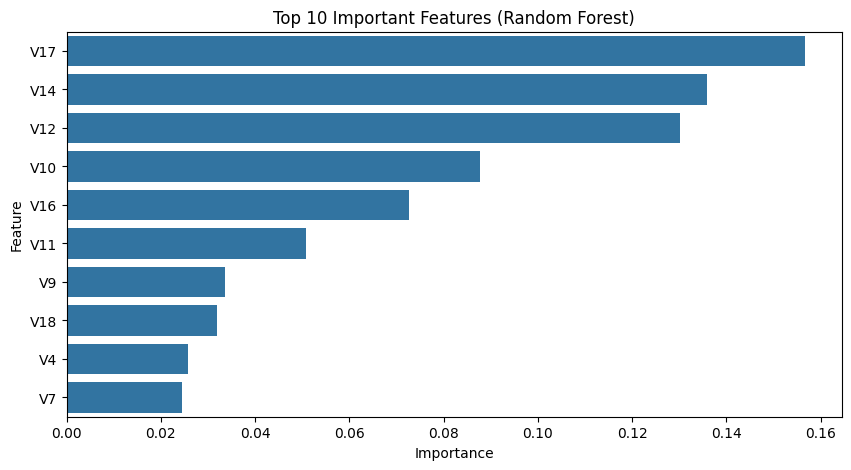

In [9]:
# Get feature importance from the trained Random Forest model to select top features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feature_importance = rf.feature_importances_

# Convert to DataFrame
features = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance
features = features.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=features.Importance[:10], y=features.Feature[:10])
plt.title("Top 10 Important Features (Random Forest)")
plt.show()


We can see from above plot that these features have the most influence on the model's ability to distinguish between genuine and fraudulent transactions.

In [10]:
# Select top 10 features based on importance
top_features = features.Feature[:10].tolist()
print("Top 10 Features Selected:", top_features)

Top 10 Features Selected: ['V17', 'V14', 'V12', 'V10', 'V16', 'V11', 'V9', 'V18', 'V4', 'V7']


In [11]:
#Retrain Model on Selected Features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

In [12]:
# Handling Class Imbalance using SMOTE (Oversampling Fraud Cases)
# Creates synthetic fraud cases to balance the dataset.
#We have used SMOTE as fraud data is very limited.

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_selected, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_sm).value_counts())

Class distribution after SMOTE:
Class
0    226602
1    226602
Name: count, dtype: int64


This shows that after SMOTE, both classes are now perfectly balanced in the training set. Initially, the fraudulent transactions were far low than the genuine transactions, but SMOTE generated synthetic data points for the fraud class, increasing its size to match that of the genuine class. 

In [13]:
X_train_sm.shape

(453204, 10)

In [14]:
y_train_sm.shape

(453204,)

In [15]:
# Train a new Random Forest and Extreme Gradient Boosting model
best_rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
best_rf_selected.fit(X_train_sm, y_train_sm)

xgb_selected = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_selected.fit(X_train_sm, y_train_sm)

# Predict and evaluate
y_pred_rf_selected = best_rf_selected.predict(X_test_selected)
print("Performance of RF with Selected Features:")
print(classification_report(y_test, y_pred_rf_selected))

y_pred_xgb_selected = xgb_selected.predict(X_test_selected)
print("\n Performance of XGB with Selected Features:")
print(classification_report(y_test, y_pred_xgb_selected))

Performance of RF with Selected Features:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.83      0.78      0.80        95

    accuracy                           1.00     56746
   macro avg       0.92      0.89      0.90     56746
weighted avg       1.00      1.00      1.00     56746


 Performance of XGB with Selected Features:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.47      0.80      0.60        95

    accuracy                           1.00     56746
   macro avg       0.74      0.90      0.80     56746
weighted avg       1.00      1.00      1.00     56746



The F1-score for RF (0.80) is higher than XGBoost (0.60), meaning that it provides a better balance between precision and recall. Also, RF has a higher precision (0.83) for fraud detection, which means that when it predicts fraud, it’s correct 83% of the time. Hence, it can minimize the risk of falsely accusing legitimate transactions of being fraud.

In [16]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred_rf_selected))
print(f1_score(y_test, y_pred_xgb_selected))

0.8043478260869565
0.596078431372549


In [17]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_rf_selected))
print(accuracy_score(y_test, y_pred_xgb_selected))

0.999365594050682
0.9981848940894512


In [18]:
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
# log_reg.fit(X_train_sm, y_train_sm)
log_reg.fit(X_train_sm, y_train_sm)

# Make predictions
y_pred_lr = log_reg.predict(X_test_selected)

# Evaluate model
print("Logistic Regression Model Performance:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.05      0.86      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.99     56746



In [19]:
print(f1_score(y_test, y_pred_lr))
print(accuracy_score(y_test, y_pred_lr))

0.09861695730607337
0.9735840411658971


In [20]:
# Hyperparameter Tuning After Feature Selection
# Define Random Forest Hyperparameter Grid
from sklearn.model_selection import GridSearchCV
param_grid_rf = {


    
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    # 'min_samples_split': [2, 5, 10]
}

# GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(best_rf_selected, param_grid_rf, cv=3, scoring='f1', verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train_sm, y_train_sm)
print("Best Hyperparameters for Random Forest:", grid_search_rf.best_params_)

# Train Random Forest with best parameters
best_rf = grid_search_rf.best_estimator_
y_pred_rf_best = best_rf.predict(X_test_selected)

# Evaluate Random Forest with selected features
print("Improved Random Forest Performance:")
print(classification_report(y_test, y_pred_rf_best))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Improved Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.83      0.78      0.80        95

    accuracy                           1.00     56746
   macro avg       0.92      0.89      0.90     56746
weighted avg       1.00      1.00      1.00     56746



Since there is no change while hyperparameter tuning, it seems Random Forest model might be performing well enough on this dataset that and didn't lead to a substantial improvement.

In [21]:
print(f1_score(y_test, y_pred_rf_best))
print(accuracy_score(y_test, y_pred_rf_best))

0.8043478260869565
0.999365594050682


In [22]:
from sklearn.model_selection import RandomizedSearchCV
# Define XGBoost Hyperparameter Grid
param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    # 'max_depth': [3, 6, 10]
}

# RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(xgb_selected, param_dist_xgb, cv=3, scoring='f1', n_iter=10, verbose=2, n_jobs=-1, random_state=42)
random_search_xgb.fit(X_train_sm, y_train_sm)
print("Best Hyperparameters for XGBoost:", random_search_xgb.best_params_)

# Train XGBoost with best parameters
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb_best = best_xgb.predict(X_test_selected)

# Evaluate XGBoost with selected features
print("Improved XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb_best))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Hyperparameters for XGBoost: {'n_estimators': 200, 'learning_rate': 0.2}
Improved XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.55      0.79      0.65        95

    accuracy                           1.00     56746
   macro avg       0.77      0.89      0.82     56746
weighted avg       1.00      1.00      1.00     56746



In [23]:
print(f1_score(y_test, y_pred_xgb_best))
print(accuracy_score(y_test, y_pred_xgb_best))

0.646551724137931
0.9985549642265534


In [24]:
# Ensemble Learning (Combining Multiple Models)
from sklearn.ensemble import VotingClassifier

# Define models
models = [
    ('Random Forest', best_rf),
    ('XGBoost', best_xgb),
    ('Logistic Regression', log_reg)
]

# Create ensemble model
ensemble = VotingClassifier(estimators=models, voting='soft')
ensemble.fit(X_train_sm, y_train_sm)

# Predict and evaluate
y_pred_ensemble = ensemble.predict(X_test_selected)
print("Ensemble Model Performance:")
print(classification_report(y_test, y_pred_ensemble))


Ensemble Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.68      0.81      0.74        95

    accuracy                           1.00     56746
   macro avg       0.84      0.90      0.87     56746
weighted avg       1.00      1.00      1.00     56746



Here, we combined Random Forest, XGBoost, and Logistic Regression into one powerful model using a VotingClassifier with soft voting. Each model has its own strengths—Random Forest handles imbalanced data well, XGBoost is great for boosting recall, and Logistic Regression helps with linear separability and easy interpretation. Instead of just picking the most common prediction (hard voting), soft voting averages the predicted probabilities, so models that are more confident in their predictions have more influence. To deal with the imbalance in fraud cases, we use SMOTE (Synthetic Minority Over-sampling Technique) to create more fraud samples and make the model learn better. By combining multiple models, we reduce overfitting, make the predictions more generalizable, and improve overall accuracy, precision, and recall, especially for those rare fraud cases.

Comparison with Previous Models:
The ensemble model outperforms individual models, particularly in recall (81%), meaning it detects more fraud cases than Random Forest (78%) and XGBoost (80%). While the precision is slightly lower than Random Forest (83%), the recall boost makes it more reliable for real-world fraud detection.

In [25]:
print(f1_score(y_test, y_pred_ensemble))
print(accuracy_score(y_test, y_pred_ensemble))

0.7368421052631579
0.9990307686885419


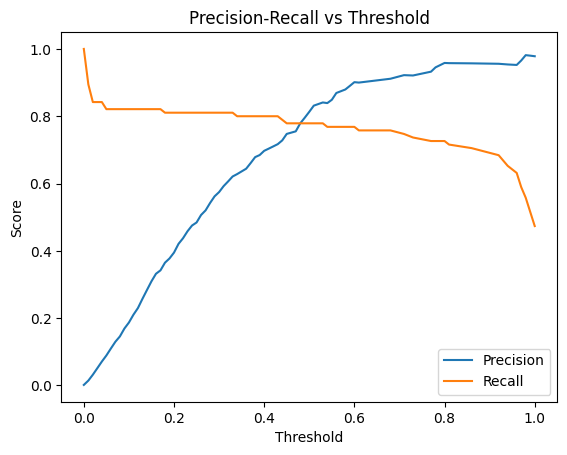

In [28]:
# Threshold Tuning to reduce False Positives
# Instead of using 0.5 as the default threshold for fraud classification, we can adjust it based on Precision-Recall tradeoff.
from sklearn.metrics import precision_recall_curve

# Get probability predictions
y_probs = best_rf.predict_proba(X_test_selected)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot Precision-Recall curve
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.savefig("precision-recall.png")
plt.show()

in this plot X-axis (Threshold) is the decision boundary for classifying a transaction as fraud whereas Y-axis (Score) has Precision (blue) and Recall (orange).

Tradeoff: As the threshold increases, precision increases but recall decreases. A lower threshold captures more fraud cases (higher recall) but may increase false positives (lower precision).
A higher threshold reduces false positives (higher precision) but may miss fraud cases (lower recall).

In [29]:
# Set new threshold (e.g., 0.3 instead of 0.5) after visualizing
custom_threshold = 0.3
y_pred_custom = (y_probs >= custom_threshold).astype(int)

# Evaluate new threshold
print("Performance with Custom Threshold:")
print(classification_report(y_test, y_pred_custom))

Performance with Custom Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.57      0.81      0.67        95

    accuracy                           1.00     56746
   macro avg       0.79      0.90      0.84     56746
weighted avg       1.00      1.00      1.00     56746



Changing the classification threshold (e.g., from 0.5 to 0.3) affects how the model makes predictions. A lower threshold means the model is more likely to label something as fraud (class 1), which can help catch more fraud cases (increasing recall) but also cause more mistakes, like labeling genuine cases as fraud (lowering precision). This is useful in cases like fraud detection, where it's better to catch as many frauds as possible, even if it means some mistakes. The threshold also affects other measures, like F1-score, which balances both recall and precision.

In [30]:
import joblib

# Save the model
joblib.dump(best_rf, "random_forest_model.pkl") 
joblib.dump(ensemble, "ensemble_model.pkl") 

['ensemble_model.pkl']

In [31]:
loaded_rf = joblib.load("random_forest_model.pkl")
loaded_ensemble= joblib.load("ensemble_model.pkl")

In [32]:
def predict_fraud():
    print("\n Enter transaction details for fraud detection ")
    
    # Dictionary to store user input
    user_input = {}

    # Prompt user for each selected feature
    for feature in top_features:
        value = float(input(f"Enter value for {feature}: "))
        user_input[feature] = value

    # Convert to DataFrame
    new_transaction = pd.DataFrame([user_input])
    

    # Ensure columns match training data
    new_transaction = new_transaction.reindex(columns=top_features, fill_value=0)


    # Standardize input data
    # new_transaction_scaled = scaler.transform(new_transaction)

    # Make predictions
    prediction = loaded_rf.predict(new_transaction)
    prediction_prob = loaded_rf.predict_proba(new_transaction)[:, 1]

    

    # Print results
    print("\n **Fraud Detection Prediction** ")
    print(f"Prediction: {'Fraud' if prediction[0] == 1 else 'Genuine'}")
    print(f"Fraud Probability: {prediction_prob[0]:.2f}")

# Run the prediction function
predict_fraud()



 Enter transaction details for fraud detection 


Enter value for V17:  -10.246755
Enter value for V14:  -8.138695
Enter value for V12:  -11.349029
Enter value for V10:  -4.594952
Enter value for V16:  -6.653594
Enter value for V11:  5.275506
Enter value for V9:  -1.498468
Enter value for V18:  -4.191066
Enter value for V4:  5.467685
Enter value for V7:   -4.104215



 **Fraud Detection Prediction** 
Prediction: Fraud
Fraud Probability: 1.00


In [ ]:
# V17   -10.246755
# V14    -8.138695
# V12   -11.349029
# V10    -4.594952
# V16    -6.653594
# V11     5.275506
# V9     -1.498468
# V18    -4.191066
# V4      5.467685
# V7     -4.104215
# a fraud case sample from given data 

In [34]:
def predict_fraud():
    print("\n Enter transaction details for fraud detection using ensemble")
    
    # Dictionary to store user input
    user_input = {}

    # Prompt user for each selected feature
    for feature in top_features:
        value = float(input(f"Enter value for {feature}: "))
        user_input[feature] = value

    # Convert to DataFrame
    new_transaction = pd.DataFrame([user_input])
    

    # Ensure columns match training data
    new_transaction = new_transaction.reindex(columns=top_features, fill_value=0)

    # Make predictions
    prediction = loaded_ensemble.predict(new_transaction)
    prediction_prob = loaded_ensemble.predict_proba(new_transaction)[:, 1]
    
    # Print results
    print("\n **Fraud Detection Prediction Using Ensemble** ")
    print(f"Prediction: {'Fraud' if prediction[0] == 1 else 'Genuine'}")
    print(f"Fraud Probability: {prediction_prob[0]:.2f}")

# Run the prediction function
predict_fraud()



 Enter transaction details for fraud detection using ensemble


Enter value for V17:  1
Enter value for V14:  2
Enter value for V12:  3
Enter value for V10:  4
Enter value for V16:  5
Enter value for V11:  6
Enter value for V9:  7
Enter value for V18:  8
Enter value for V4:  9
Enter value for V7:  3



 **Fraud Detection Prediction Using Ensemble** 
Prediction: Genuine
Fraud Probability: 0.11


In [ ]:
# y_train_sm[y_train_sm == 1].index[250]

In [ ]:
# loaded_rf.predict(pd.DataFrame(X_train_sm.iloc[226238]).T)

In [ ]:
# loaded_rf.predict(pd.DataFrame(X_train_sm.iloc[159179]).T)

In [ ]:
# X_train_sm.iloc[159179]